<a href="https://colab.research.google.com/github/BeytullahYayla/Aerial-Image-Segmentation-With-Unet/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 2.6 MB/s 
     |████████████████████████████████| 58 kB 3.0 MB/s 
     |████████████████████████████████| 376 kB 22.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=365ce5d3ba79ad109e2b1535dcaff4149e017c65397275411dfff2649a6ec903
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=2ebcb51fbbb477f484036a665909a5544126e14d521d74d89749911d7f8b6bfd
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

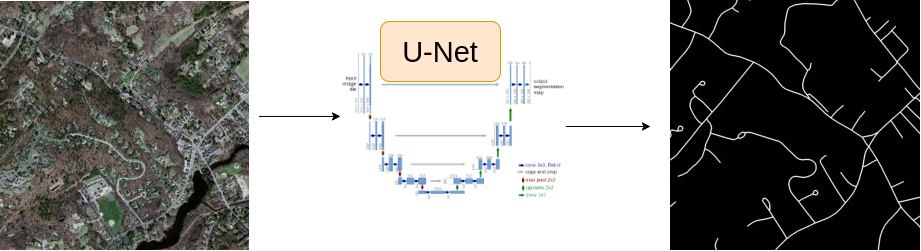

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 30.08 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [37]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE="/content/Road_seg_dataset/train.csv"
DATA_DIR="/content/Road_seg_dataset/"

DEVICE="cuda"
LR=0.03

BATCH_SIZE=8
IMG_SIZE=512
ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'
EPOCHS=25




In [6]:
df=pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx=10
row=df.iloc[idx]



image_path=DATA_DIR+row.images
mask_path=DATA_DIR+row.masks

image_path

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255




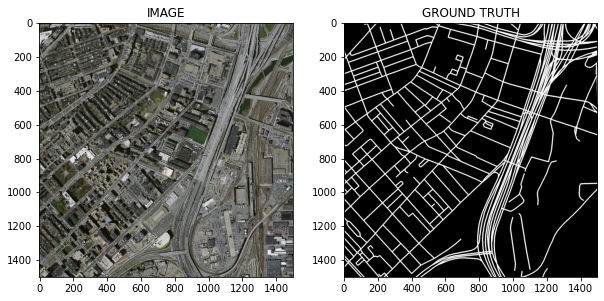

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df,val_df=train_test_split(df,test_size=0.25,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentation):
    self.df=df
    self.augmentation=augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row=df.iloc[idx]

    image_path=DATA_DIR+row.images
    mask_path=DATA_DIR+row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,-1)

    if self.augmentation:
      data=self.augmentation(image=image,mask=mask)
      image=data["image"]
      mask=data["mask"]

    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask



In [14]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(val_df,get_valid_augs())

In [15]:
print(f"Length of trainset:{len(trainset)}")
print(f"Length of validset:{len(validset)}")

Length of trainset:149
Length of validset:50


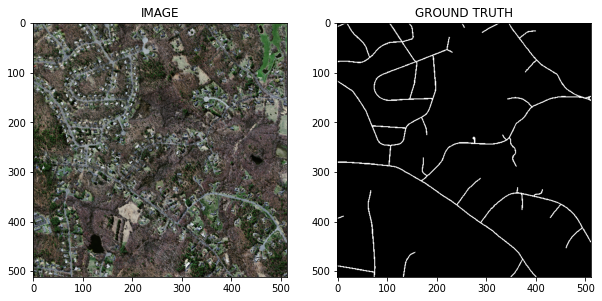

In [16]:
idx=20
image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
train_loader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=DataLoader(validset,BATCH_SIZE)

In [19]:
print(f'Total number of batches in trainLoader:{len(train_loader)}')
print(f'Total number of batches in valid_loader:{len(valid_loader)}')

Total number of batches in trainLoader:19
Total number of batches in valid_loader:7


In [20]:
for image,mask in train_loader:
  print(f'Dimension of image in one batch of train loader{image.shape}')
  print(f'Dimension of mask in one batch of train loader{mask.shape}')

  break

Dimension of image in one batch of train loadertorch.Size([8, 3, 512, 512])
Dimension of mask in one batch of train loadertorch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss


from torch import nn

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.backbone=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self,image,mask=None):
    logits=self.backbone(image)



    if mask!=None:
      return logits,DiceLoss(mode="binary")(logits,mask)+nn.BCEWithLogitsLoss()(logits,mask)

    return logits

In [23]:
model=SegmentationModel()


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function 

In [24]:
from torch.nn.modules import loss
def train_func(data_loader,model,optimizer):

  model.train()#Turn on Dropout,BatchNorm etc

  total_loss=0.0

  for images,masks in tqdm(data_loader):

     

    optimizer.zero_grad()
    logits,loss=model(images,masks)

    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)


In [25]:
from torch.nn.modules import loss
def eval_func(data_loader,model,optimizer):

  model.eval()#Turn off Droput,BatchNorm etc.

  total_loss=0.0

  with torch.no_grad():

    for images,masks in tqdm(data_loader):

     


      
      logits,loss=model(images,masks)
      total_loss+=loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [27]:
best_loss=np.Inf
for i in range(EPOCHS):
  train_loss=train_func(train_loader,model,optimizer)
  valid_loss=eval_func(valid_loader,model,optimizer)

  if valid_loss<best_loss:
    torch.save(model.state_dict(),"best_model.pt")
    print("Saved model")
    best_loss=valid_loss

  print(f"Epoch {i+1}, Training loss:{train_loss}  Validation_loss:{valid_loss}")

100%|██████████| 7/7 [00:42<00:00,  6.07s/it]


Saved model
Epoch 1, Training loss:1.1433609410336143  Validation_loss:729.5404881068638


100%|██████████| 7/7 [00:40<00:00,  5.82s/it]


Saved model
Epoch 2, Training loss:1.034625254179302  Validation_loss:1.1256378037588937


100%|██████████| 7/7 [00:40<00:00,  5.80s/it]


Saved model
Epoch 3, Training loss:0.9943077532868636  Validation_loss:1.053898879459926


100%|██████████| 7/7 [00:41<00:00,  5.98s/it]


Epoch 4, Training loss:0.9790929806859869  Validation_loss:1.3641784191131592


100%|██████████| 7/7 [00:40<00:00,  5.80s/it]


Saved model
Epoch 5, Training loss:0.9977550381108334  Validation_loss:1.0230074524879456


100%|██████████| 7/7 [00:40<00:00,  5.75s/it]


Saved model
Epoch 6, Training loss:0.950859690967359  Validation_loss:0.9748960903712681


100%|██████████| 7/7 [00:40<00:00,  5.83s/it]


Epoch 7, Training loss:0.9135706361971403  Validation_loss:1.0112698333603996


100%|██████████| 7/7 [00:41<00:00,  5.89s/it]


Epoch 8, Training loss:0.9078633942102131  Validation_loss:1.2752876792635237


100%|██████████| 7/7 [00:42<00:00,  6.09s/it]


Saved model
Epoch 9, Training loss:0.8957516896097284  Validation_loss:0.9639777030263629


100%|██████████| 7/7 [00:41<00:00,  5.90s/it]


Saved model
Epoch 10, Training loss:0.8471424956070749  Validation_loss:0.8311188987323216


100%|██████████| 7/7 [00:42<00:00,  6.03s/it]


Saved model
Epoch 11, Training loss:0.7906280505029779  Validation_loss:0.7974522539547512


100%|██████████| 7/7 [00:41<00:00,  5.88s/it]


Saved model
Epoch 12, Training loss:0.754755365221124  Validation_loss:0.7745852981294904


100%|██████████| 7/7 [00:40<00:00,  5.84s/it]


Epoch 13, Training loss:0.7459602261844435  Validation_loss:0.7885866676058088


100%|██████████| 7/7 [00:41<00:00,  5.96s/it]


Saved model
Epoch 14, Training loss:0.7421663340769316  Validation_loss:0.7566941891397748


100%|██████████| 7/7 [00:42<00:00,  6.03s/it]


Epoch 15, Training loss:0.726796335295627  Validation_loss:0.7689167090824672


100%|██████████| 7/7 [00:41<00:00,  5.94s/it]


Epoch 16, Training loss:0.7099695644880596  Validation_loss:0.8094623684883118


100%|██████████| 7/7 [00:42<00:00,  6.07s/it]


Epoch 17, Training loss:0.7154782665403265  Validation_loss:0.7727530087743487


100%|██████████| 7/7 [00:41<00:00,  5.96s/it]


Saved model
Epoch 18, Training loss:0.7031366291799044  Validation_loss:0.7395391464233398


100%|██████████| 7/7 [00:41<00:00,  5.94s/it]


Epoch 19, Training loss:0.7128322093110335  Validation_loss:0.7436910697392055


100%|██████████| 7/7 [00:41<00:00,  5.96s/it]


Saved model
Epoch 20, Training loss:0.7063253710144445  Validation_loss:0.7049845201628548


100%|██████████| 7/7 [00:41<00:00,  5.87s/it]


Epoch 21, Training loss:0.6850698903987282  Validation_loss:0.7156688485826764


100%|██████████| 7/7 [00:41<00:00,  5.93s/it]


Epoch 22, Training loss:0.6812643314662733  Validation_loss:0.7345378569194249


100%|██████████| 7/7 [00:41<00:00,  5.89s/it]


Epoch 23, Training loss:0.6779111937472695  Validation_loss:0.7242563366889954


100%|██████████| 7/7 [00:41<00:00,  5.97s/it]


Epoch 24, Training loss:0.6654034413789448  Validation_loss:0.7757741553442818


100%|██████████| 7/7 [00:40<00:00,  5.79s/it]

Saved model
Epoch 25, Training loss:0.6741062465466952  Validation_loss:0.6957291534968785


# Task 9 : Inference

In [31]:
idx=17
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask=validset[idx]

logits_mask=model(image.unsqueeze(0))#(c,h,w)--->(b,c,h,w)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

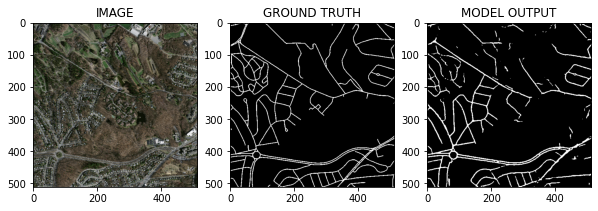

In [35]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

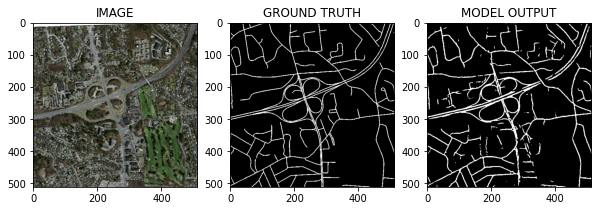

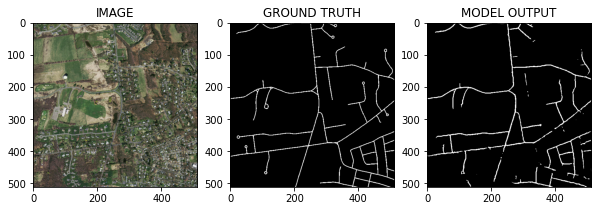

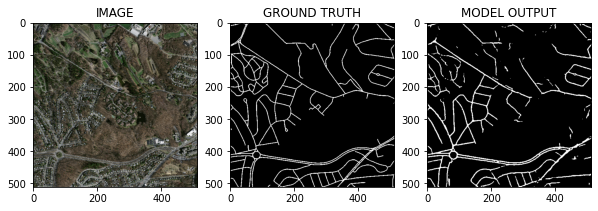

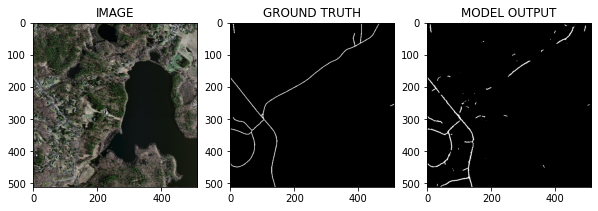

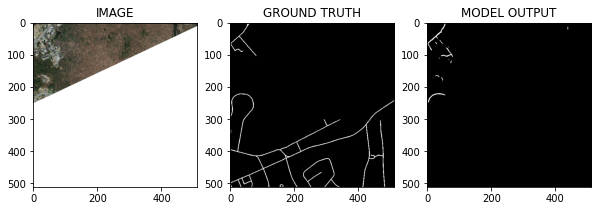

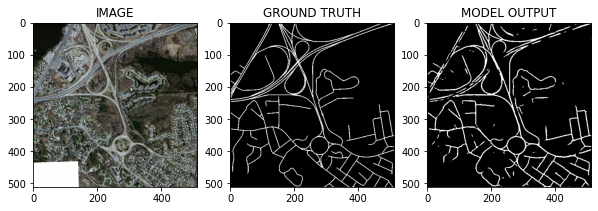

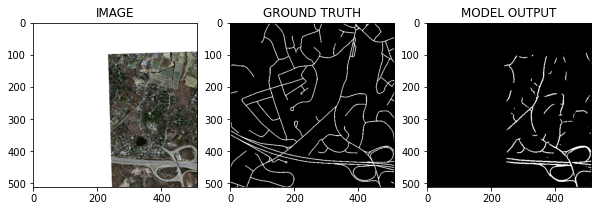

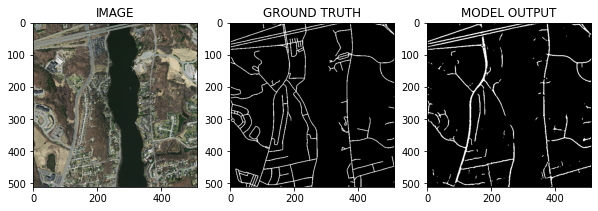

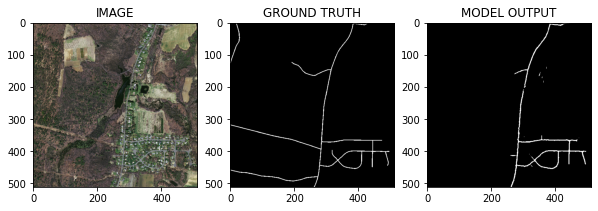

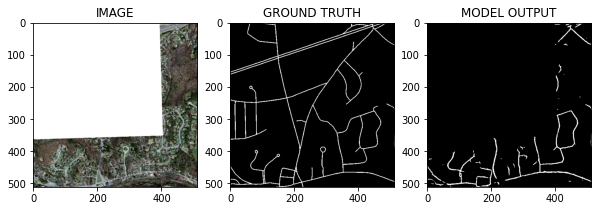

In [42]:
for i in range(10):
  randm=random.randint(0,len(image_path)-1)
  image,mask=validset[randm]

  logits_mask=model(image.unsqueeze(0))#(c,h,w)--->(b,c,h,w)
  pred_mask=torch.sigmoid(logits_mask)
  pred_mask=(pred_mask>0.5)*1.0
  
  helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))
  
  